# SVM implementation

In [ ]:
import numpy as np
from copy import copy
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Initializing random seed and global path variables

In [ ]:
# Initializing

np.random.seed(42)
TRAINING_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_train_processed.csv'
TESTING_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_test_processed.csv'
EVAL_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_eval_processed.csv'

TRAINING_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_train.csv'
TESTING_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_test.csv'
EVAL_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_eval.csv'

TRAINING_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_train.csv'
TESTING_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_test.csv'
EVAL_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_eval.csv'

TRAINING_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_train.csv'
TESTING_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_test.csv'
EVAL_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_eval.csv'

EVAL_IDS = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/data/eval.ids'

# Feature vector paths
X_TRAIN = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/extracted features/X_train_vec.npy'
y_TRAIN = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/extracted features/y_train_vec.npy'

X_TEST = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/extracted features/X_test_vec.npy'
y_TEST = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/extracted features/y_test_vec.npy'

X_EVAL = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/extracted features/X_eval_vec.npy'
y_EVAL = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/extracted features/y_eval_vec.npy'



## Data class

w/ some other helper functions

In [ ]:
# Defining Data class
# Will define new data class using csv and numpy

class Data:
  def __init__(self,file_path=None):
    if file_path != None:
      self.raw_data,\
      self.y,\
      self.X,\
      self.num_examples,\
      self.num_features = self.load_data_from_path(file_path)

  def load_data_from_path(self,file_path):
    # data = np.loadtxt(file_path, delimiter = ",")
    raw_data = pd.read_csv(file_path)
    data = raw_data.to_numpy()
    labels = data[:,0]
    instances = data[:,1:]

    # Add a 1 to the end of each instance
    bias = np.ones((data.shape[0],1))
    instances = np.append(instances,bias,axis=1)

    num_examples = data.shape[0]
    num_features = instances.shape[1]
    return data,labels,instances,num_examples,num_features

  def load_data(self,raw_data):
    self.raw_data = raw_data
    self.y = raw_data[:,0]
    self.y[self.y == 0] = - 1
    instances = raw_data[:,1:]
    # Add a 1 to the end of each instance
    bias = np.ones((raw_data.shape[0],1))
    self.X = np.append(instances,bias,axis=1)
    self.num_examples = raw_data.shape[0]
    self.num_features = self.X.shape[1]

  # For loading in feature vectors from NN
  def load_data_np(self,X,y):
    y[y==0] = -1
    self.raw_data = np.append(y,X,axis=1)
    bias = np.ones((X.shape[0],1))
    self.X = np.append(X,bias,axis=1)
    self.y = np.ravel(y)
    self.num_examples = X.shape[0]
    self.num_features = self.X.shape[1]

  def add_bias_to_features(self):
    # Add a 1 to the end of each instance
    bias = np.ones((self.num_examples,1))
    self.X = np.append(self.X,bias,axis=1)

  def add_data(self,data):
    # takes as input another data object and adds that data to this object
    self.raw_data = np.vstack((self.raw_data,data.raw_data))
    self.X = np.vstack((self.X,data.X))
    self.y = np.hstack((self.y,data.y))
    self.num_examples += data.num_examples

  # returns shuffled labels and instances
  def shuffle_data(self):
    shuffled_raw_data = np.copy(self.raw_data)
    np.random.shuffle(shuffled_raw_data)
    shuffled_labels = shuffled_raw_data[:,0]
    shuffled_instances = shuffled_raw_data[:,1:]
    # add in bias
    bias = np.ones((shuffled_raw_data.shape[0],1))
    shuffled_instances = np.append(shuffled_instances,bias,axis=1)

    return shuffled_instances,shuffled_labels


# plot learning curve
def plot_learning(x,y,title,x_label,y_label):
  # Let's plot
  plt.style.use('default')
  plt.rcParams['font.family'] = 'Avenir'
  plt.figure(figsize = (11,4.5))
  # My PCA
  plt.plot(x,y)
  plt.title(title,fontsize=15)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  [i.set_linewidth(0.4) for i in plt.gca().spines.values()]


SVM class from hw6, may need to make some adjustments to accomodate this dataset.

In [ ]:
# SVM Class

class SVM:
  def __init__(self):
    self.W = None
    self.Weights = {} # init empty dict of Weights, add to this for each epoch
    self.accuracies = {} # init empty dict of accuracies, which I store at end of each epoch
    self.loss = {} # dictionary contatining loss at each step
    self.num_updates = 0 # records number of updates made 

  def initialize_weights(self,num_features):
    self.W = np.array([np.random.uniform(-0.01,0.01) for _ in range(num_features)])
    # self.W = np.zeros((num_features)) # init to zeros
  
  def train(self,data,epochs=1,learning_rate=1,reg_strength=1):
    C = reg_strength
    epochs = epochs
    N = data.num_examples
    D = data.num_features
    # print("N:",N,"D (including b):",D)
    # initialize weights
    self.initialize_weights(D)
    
    for t in range(epochs):
      lr = learning_rate / (1 + t) # we use a decaying learning rate
      # shuffle data
      X,y = data.shuffle_data()
      # loop over each example in the training set
      for i in range(N):
        v = y[i]*(self.W.T.dot(X[i]))
        # print(v)
        if v <= 1.0: 
          self.W = (1.0-lr)*self.W + (lr*C*y[i])*X[i]
        else:
          self.W = (1.0-lr)*self.W
      # store this iteration of weights 
      self.Weights[t] = self.W
      # store the accuracy of these weights
      self.accuracies[t] = self.get_accuracy_own_weights(data,self.W)
      # Compute and store the loss 
      self.loss[t] = self.compute_loss(data,self.W,C)


  # Helper methods for predicting and accuracy
  def get_best_weights_and_bias(self):
    # print(self.accuracies.items())
    best_epoch = max(self.accuracies,key=self.accuracies.get)
    # print("best epoch: ",best_epoch)
    return self.Weights[best_epoch],best_epoch

  def predict(self,data):
    predictions = np.sign(data.dot(self.W))
    return predictions

  def get_predict_accuracy(self,data):
    predictions = self.predict(data.X)
    equal = np.equal(predictions,data.y)
    return np.sum(equal)/data.num_examples

  def get_accuracy_own_weights(self,data,W):
    predictions = np.sign(data.X.dot(W)) # Should the prediction have a margin? No, I don't think so
    equal = np.equal(predictions,data.y)
    return np.sum(equal)/data.num_examples

  def compute_loss(self,data,W,C):
    # "Loss" of the entire dataset
    X = data.X
    y = data.y
    loss = 0.5*(W.T.dot(W)) 
    a = 1 - y*W.dot(X.T)
    a[a<0] = 0
    return loss + C*np.sum(a)

## Load data

Takes a while b/c I'm loading from csv.

In [ ]:

# TF-IDF + Misc
# train_data = Data(TRAINING_PATH_TF)
# test_data = Data(TESTING_PATH_TF)

# NN feature vecs
train_data = Data()
test_data = Data()
eval_data = Data()

X_train = np.load(X_TRAIN)
y_train = np.load(y_TRAIN)
X_test = np.load(X_TEST)
y_test = np.load(y_TEST)
X_eval = np.load(X_EVAL)
y_eval = np.load(y_EVAL)

train_data.load_data_np(X_train,y_train)
test_data.load_data_np(X_test,y_test)
eval_data.load_data_np(X_eval,y_eval)


# Glove + Misc
# train_data = Data(TRAINING_PATH_GLOVE)
# test_data = Data(TESTING_PATH_GLOVE)

# BOW + Misc
# train_data = Data(TRAINING_PATH_BOW)
# test_data = Data(TESTING_PATH_BOW)

# # Misc
# misc_train_data = Data(TRAINING_PATH)
# misc_test_data = Data(TESTING_PATH)


In [ ]:
train_data.y

array([ 1.,  1., -1., ...,  1.,  1.,  1.])

## Initial training 

Try some params I think may be good and see how long it takes/ how good the params are.

CPU times: user 1.63 s, sys: 894 ms, total: 2.52 s
Wall time: 1.45 s
best training set accuracy:  0.9009714285714285
final test accuracy:  0.8404444444444444


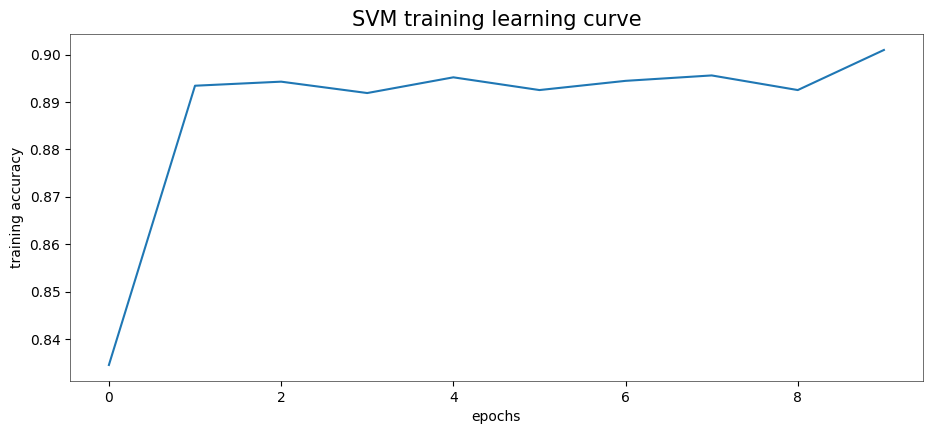

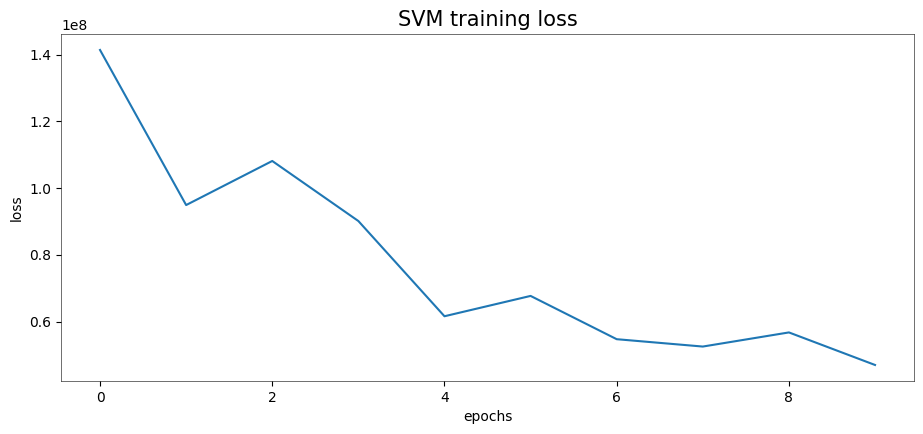

In [ ]:
learning_rate = 0.00001
C = 10000

epochs = 10
svm = SVM()
%time svm.train(train_data,epochs,learning_rate,C)

# test set accuracy
# Get the best weights and bias from this training
W,best_epoch = svm.get_best_weights_and_bias()
# training set accuracy:
print("best training set accuracy: ", svm.accuracies[best_epoch] )
# Use these weights and bias to evaluate on the test set
test_accuracy = svm.get_accuracy_own_weights(test_data,W)
print("final test accuracy: ",test_accuracy)

y = list(svm.accuracies.values())
x = [i for i in range(epochs)]
title = 'SVM training learning curve'
plot_learning(x,y,title,'epochs','training accuracy')

y = list(svm.loss.values())
x = [i for i in range(epochs)]
title = 'SVM training loss'
plot_learning(x,y,title,'epochs','loss')


## Make cross validation folds

In [ ]:
# Validation splits - split training data into k splits

k = 3
folds = np.array_split(train_data.raw_data,k)

## Cross validate

Will use tf-idf + misc attributes b/c this is what's worked the best in the past. Once I get the best params, will run on other datasets just to confirm.

Not using an exhaustive search b/c this takes FOREVER.

In [ ]:
def cross_validate(epochs,folds,learning_rates,regularizations,verbose=False,model=SVM()):

  # dictionaries storing accuracies corresponding to certain hyper parameter combinations
  mean_accuracies = {} 
  standard_deviations = {}

  num_combs = len(learning_rates)*len(regularizations)
  progress = 0
  
  for lr in tqdm(learning_rates):
    for C in tqdm(regularizations):
      accuracies = []
      # Need to concatenate 4 of the folds into one training set and leave out one as my test set
      for i in tqdm(range(k)):
        # Initialize new data objects
        val_data = Data()
        train_data = Data()
        folds_copy = list.copy(folds)
        # Set validation data
        val_data.load_data(np.array(folds_copy.pop(i)))
        # set training data
        train_data.load_data(np.concatenate(folds_copy,axis=0))
        # train on folds
        svm = model
        svm.train(train_data,epochs,lr,C)
        weights,best_epoch = svm.get_best_weights_and_bias()
        # calculate validation accuracy
        val_accuracy = svm.get_accuracy_own_weights(val_data,weights)
        accuracies.append(val_accuracy)

      mean_accuracies[(lr,C)] = np.mean(accuracies)
      standard_deviations[(lr,C)] = np.std(accuracies)
      if verbose == True:
        print("accuracy: ",mean_accuracies[(lr,C)],"lr: ",lr,"C: ",C)
        # print("list",accuracies)
        progress += 1
        print("{:.4}% complete".format(100*progress/num_combs))

  print(mean_accuracies.items())
  print(standard_deviations.items())
  best_vals = max(mean_accuracies,key=mean_accuracies.get)
  print("best lr: ",best_vals[0],"best C: ",best_vals[1],"cross-val accuracy: ",mean_accuracies[best_vals])
  return best_vals

In [ ]:
# cross validate svm

epochs = 4
# learning_rates = [10**0, 10**-1, 10**-2, 10**-3, 10**-4]
learning_rates = [10**0, 10**-2, 10**-4, 10**-4]
# regularizations = [10**3, 10**2, 10**1, 10**0, 10**-1, 10**-2]
regularizations = [10**5, 10**4, 10**3, 10**-1, 10**-2]

best_vals = cross_validate(epochs,folds,learning_rates,regularizations,verbose=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:00,  2.23it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.19it/s]

100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

 20%|██        | 1/5 [00:01<00:05,  1.43s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8877715780340493 lr:  1 C:  100000
5.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.17it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.14it/s]

100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

 40%|████      | 2/5 [00:02<00:04,  1.43s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8872002441473565 lr:  1 C:  10000
10.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.13it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.13it/s]

100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

 60%|██████    | 3/5 [00:04<00:02,  1.44s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.887714451502131 lr:  1 C:  1000
15.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.00it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.98it/s]

100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

 80%|████████  | 4/5 [00:05<00:01,  1.46s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8874287110935944 lr:  1 C:  0.1
20.0% complete




 33%|███▎      | 1/3 [00:00<00:01,  1.83it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.84it/s]

100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8870859519020854 lr:  1 C:  0.01
25.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.17it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.17it/s]

100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

 20%|██        | 1/5 [00:01<00:05,  1.43s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.888171669460009 lr:  0.01 C:  100000
30.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.23it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.22it/s]

100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

 40%|████      | 2/5 [00:02<00:04,  1.42s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8878858800746791 lr:  0.01 C:  10000
35.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.25it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.25it/s]

100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

 60%|██████    | 3/5 [00:04<00:02,  1.43s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8883430098743289 lr:  0.01 C:  1000
40.0% complete




 33%|███▎      | 1/3 [00:00<00:01,  1.98it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.97it/s]

100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

 80%|████████  | 4/5 [00:05<00:01,  1.46s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8878288417009891 lr:  0.01 C:  0.1
45.0% complete




 33%|███▎      | 1/3 [00:00<00:01,  1.82it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.81it/s]

100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8873716629245458 lr:  0.01 C:  0.01
50.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.27it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.24it/s]

100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

 20%|██        | 1/5 [00:01<00:05,  1.35s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8924001494928463 lr:  0.0001 C:  100000
55.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.17it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.20it/s]

100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

 40%|████      | 2/5 [00:02<00:04,  1.36s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8912571584726239 lr:  0.0001 C:  10000
60.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.18it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.19it/s]

100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

 60%|██████    | 3/5 [00:04<00:02,  1.37s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8932573511277386 lr:  0.0001 C:  1000
65.0% complete




 33%|███▎      | 1/3 [00:00<00:01,  1.95it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.96it/s]

100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

 80%|████████  | 4/5 [00:05<00:01,  1.43s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8871431372061557 lr:  0.0001 C:  0.1
70.0% complete




 33%|███▎      | 1/3 [00:00<00:01,  1.79it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.79it/s]

100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.88777164660156 lr:  0.0001 C:  0.01
75.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.27it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.24it/s]

100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

 20%|██        | 1/5 [00:01<00:05,  1.36s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8927430654100945 lr:  0.0001 C:  100000
80.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.23it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.18it/s]

100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

 40%|████      | 2/5 [00:02<00:04,  1.37s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8911429347948635 lr:  0.0001 C:  10000
85.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.12it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.12it/s]

100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

 60%|██████    | 3/5 [00:04<00:02,  1.40s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8947429837951658 lr:  0.0001 C:  1000
90.0% complete




 33%|███▎      | 1/3 [00:00<00:00,  2.03it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.03it/s]

100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

 80%|████████  | 4/5 [00:05<00:01,  1.44s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.887257390269992 lr:  0.0001 C:  0.1
95.0% complete




 33%|███▎      | 1/3 [00:00<00:01,  1.80it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.80it/s]

100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

100%|██████████| 4/4 [00:29<00:00,  7.46s/it]

accuracy:  0.88708599108352 lr:  0.0001 C:  0.01
100.0% complete
dict_items([((1, 100000), 0.8877715780340493), ((1, 10000), 0.8872002441473565), ((1, 1000), 0.887714451502131), ((1, 0.1), 0.8874287110935944), ((1, 0.01), 0.8870859519020854), ((0.01, 100000), 0.888171669460009), ((0.01, 10000), 0.8878858800746791), ((0.01, 1000), 0.8883430098743289), ((0.01, 0.1), 0.8878288417009891), ((0.01, 0.01), 0.8873716629245458), ((0.0001, 100000), 0.8927430654100945), ((0.0001, 10000), 0.8911429347948635), ((0.0001, 1000), 0.8947429837951658), ((0.0001, 0.1), 0.887257390269992), ((0.0001, 0.01), 0.88708599108352)])
dict_items([((1, 100000), 0.0018965804852136825), ((1, 10000), 0.003028456901767259), ((1, 1000), 0.0021092087159003234), ((1, 0.1), 0.0017409743573305186), ((1, 0.01), 0.0029411854405172275), ((0.01, 100000), 0.002993961903065139), ((0.01, 10000), 0.002052727291628621), ((0.01, 1000), 0.0023109083273435624), ((0.01, 0.1), 0.003345182793206244), ((0.01, 0.01), 0.002903348227762886), 

## TF-IDF + misc data
From this limited cross val I got:

best lr:  0.0001 best C:  1000 cross-val accuracy:  0.790914307204743

However, it's worth noting that for every other learning rate, lower C's worked better. I'm going to hand test a few other values exploring this.

lr: 0.0001; C = 0.01: acc: 0.782514285714285.  
lr: 0.0001; C = 10000: acc: 0.8330285714285715.   
lr: 0.0001; C = 100000 acc: 0.84.    
lr: 0.00001; C = 100000; accc: 0.89.    

Seems that smaller learning rates and bigger C's do pretty well. Let's try cross val with a slightly different range.
 


## Feat Vec Data

best lr:  0.0001 best C:  1000 cross-val accuracy:  0.8947429837951658

In [ ]:
# cross validate svm

epochs = 4
# learning_rates = [10**0, 10**-1, 10**-2, 10**-3, 10**-4]
learning_rates = [10**-4, 10**-5, 10**-6]
# regularizations = [10**3, 10**2, 10**1, 10**0, 10**-1, 10**-2]
regularizations = [10**5, 10**4, 10**3]

best_vals = cross_validate(epochs,folds,learning_rates,regularizations,verbose=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:47<01:34, 47.33s/it]

 67%|██████▋   | 2/3 [01:32<00:46, 46.70s/it]

100%|██████████| 3/3 [02:17<00:00, 45.71s/it]

 33%|███▎      | 1/3 [02:17<04:34, 137.14s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7905702060490923 lr:  0.0001 C:  100000
11.11% complete




 33%|███▎      | 1/3 [00:46<01:33, 46.94s/it]

 67%|██████▋   | 2/3 [01:32<00:46, 46.56s/it]

100%|██████████| 3/3 [02:18<00:00, 46.04s/it]

 67%|██████▋   | 2/3 [04:35<02:17, 137.43s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8006281881076392 lr:  0.0001 C:  10000
22.22% complete




 33%|███▎      | 1/3 [00:48<01:36, 48.11s/it]

 67%|██████▋   | 2/3 [01:34<00:47, 47.67s/it]

100%|██████████| 3/3 [02:21<00:00, 47.06s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7946287072224686 lr:  0.0001 C:  1000
33.33% complete




 33%|███▎      | 1/3 [00:46<01:32, 46.30s/it]

 67%|██████▋   | 2/3 [01:31<00:45, 45.91s/it]

100%|██████████| 3/3 [02:16<00:00, 45.53s/it]

 33%|███▎      | 1/3 [02:16<04:33, 136.60s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8166283971797753 lr:  1e-05 C:  100000
44.44% complete




 33%|███▎      | 1/3 [00:47<01:35, 47.84s/it]

 67%|██████▋   | 2/3 [01:33<00:47, 47.23s/it]

100%|██████████| 3/3 [02:19<00:00, 46.50s/it]

 67%|██████▋   | 2/3 [04:36<02:17, 137.48s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8113712869394974 lr:  1e-05 C:  10000
55.56% complete




 33%|███▎      | 1/3 [00:48<01:36, 48.16s/it]

 67%|██████▋   | 2/3 [01:33<00:47, 47.45s/it]

100%|██████████| 3/3 [02:20<00:00, 46.80s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7854857585965586 lr:  1e-05 C:  1000
66.67% complete




 33%|███▎      | 1/3 [00:49<01:38, 49.28s/it]

 67%|██████▋   | 2/3 [01:35<00:48, 48.29s/it]

100%|██████████| 3/3 [02:21<00:00, 47.02s/it]

 33%|███▎      | 1/3 [02:21<04:42, 141.06s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8142856804217599 lr:  1e-06 C:  100000
77.78% complete




 33%|███▎      | 1/3 [00:48<01:37, 48.95s/it]

 67%|██████▋   | 2/3 [01:34<00:48, 48.07s/it]

100%|██████████| 3/3 [02:21<00:00, 47.09s/it]

 67%|██████▋   | 2/3 [04:42<02:21, 141.13s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7851428818607452 lr:  1e-06 C:  10000
88.89% complete




 33%|███▎      | 1/3 [00:49<01:39, 49.89s/it]

 67%|██████▋   | 2/3 [01:36<00:48, 48.98s/it]

100%|██████████| 3/3 [02:23<00:00, 47.86s/it]

100%|██████████| 3/3 [20:58<00:00, 419.66s/it]

accuracy:  0.7813142875513353 lr:  1e-06 C:  1000
100.0% complete
dict_items([((0.0001, 100000), 0.7905702060490923), ((0.0001, 10000), 0.8006281881076392), ((0.0001, 1000), 0.7946287072224686), ((1e-05, 100000), 0.8166283971797753), ((1e-05, 10000), 0.8113712869394974), ((1e-05, 1000), 0.7854857585965586), ((1e-06, 100000), 0.8142856804217599), ((1e-06, 10000), 0.7851428818607452), ((1e-06, 1000), 0.7813142875513353)])
dict_items([((0.0001, 100000), 0.016974295624119985), ((0.0001, 10000), 0.01564417849186136), ((0.0001, 1000), 0.005711935916112951), ((1e-05, 100000), 0.008197467218562479), ((1e-05, 10000), 0.002681656451041084), ((1e-05, 1000), 0.0012468657853124219), ((1e-06, 100000), 0.0010656962430592408), ((1e-06, 10000), 0.0006380130153082933), ((1e-06, 1000), 0.0006303148400841053)])
best lr:  1e-05 best C:  100000 cross-val accuracy:  0.8166283971797753


Ok, this second cross validation yielded:

best lr:  1e-05 best C:  100000 cross-val accuracy:  0.8166283971797753.   

So, let's train with these params.

CPU times: user 2.47 s, sys: 1.41 s, total: 3.88 s
Wall time: 2.19 s
best training set accuracy:  0.9001714285714286
final test accuracy:  0.8342222222222222


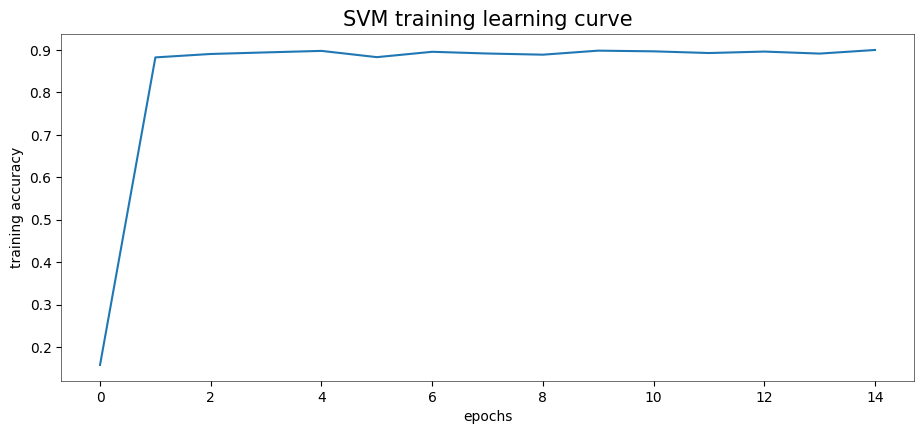

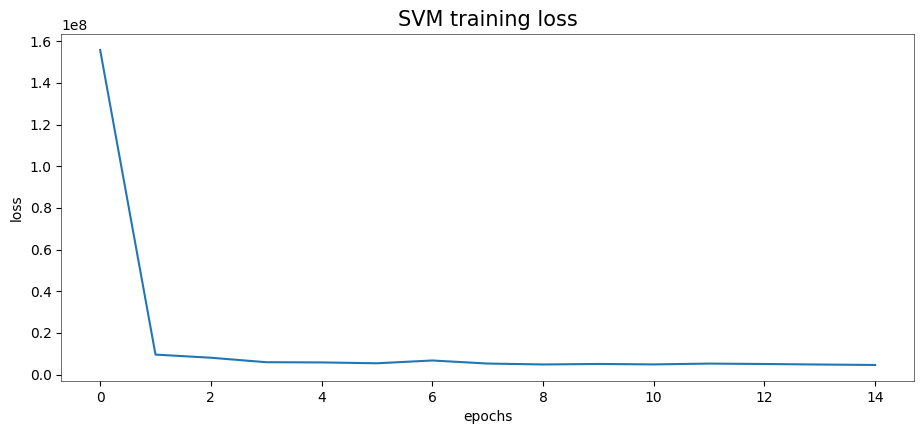

In [ ]:
# TF-IDF + misc data
# learning_rate = 0.00001
# C = 100000

# Feat vec data
learning_rate = 0.0001
C = 1000
#best lr:  0.0001 best C:  1000 cross-val accuracy:  0.8947429837951658

epochs = 15
svm = SVM()
%time svm.train(train_data,epochs,learning_rate,C)

# test set accuracy
# Get the best weights and bias from this training
W,best_epoch = svm.get_best_weights_and_bias()
# training set accuracy:
print("best training set accuracy: ", svm.accuracies[best_epoch] )
# Use these weights and bias to evaluate on the test set
test_accuracy = svm.get_accuracy_own_weights(test_data,W)
print("final test accuracy: ",test_accuracy)

y = list(svm.accuracies.values())
x = [i for i in range(epochs)]
title = 'SVM training learning curve'
plot_learning(x,y,title,'epochs','training accuracy')

y = list(svm.loss.values())
x = [i for i in range(epochs)]
title = 'SVM training loss'
plot_learning(x,y,title,'epochs','loss')


I wonder if using any of the other datasets would perform better? Let's try a few.

In [ ]:

# Misc
misc_train_data = Data(TRAINING_PATH)
misc_test_data = Data(TESTING_PATH)

CPU times: user 2.71 s, sys: 1.4 s, total: 4.11 s
Wall time: 2.42 s
best training set accuracy:  0.7813142857142857
final test accuracy:  0.7902222222222223


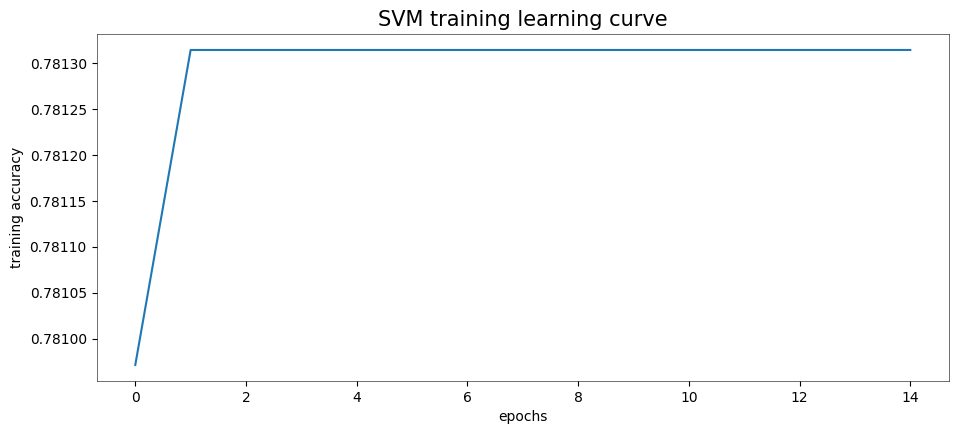

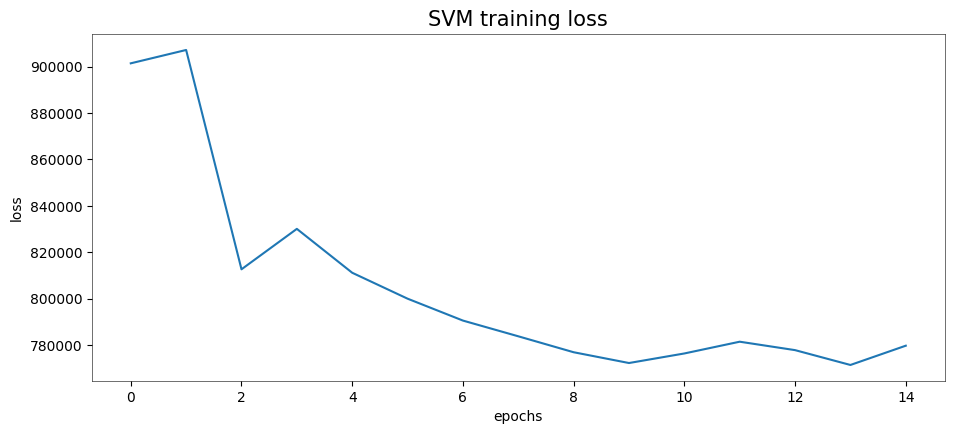

In [ ]:
learning_rate = 0.001
C = 100

epochs = 15
svm = SVM()
%time svm.train(misc_train_data,epochs,learning_rate,C)

# test set accuracy
# Get the best weights and bias from this training
W_misc,best_epoch_misc = svm.get_best_weights_and_bias()
# training set accuracy:
print("best training set accuracy: ", svm.accuracies[best_epoch_misc] )
# Use these weights and bias to evaluate on the test set
test_accuracy = svm.get_accuracy_own_weights(misc_test_data,W_misc)
print("final test accuracy: ",test_accuracy)

y = list(svm.accuracies.values())
x = [i for i in range(epochs)]
title = 'SVM training learning curve'
plot_learning(x,y,title,'epochs','training accuracy')

y = list(svm.loss.values())
x = [i for i in range(epochs)]
title = 'SVM training loss'
plot_learning(x,y,title,'epochs','loss')


Misc data actually looks kind of good... let's run some cross val on it?

In [ ]:
# Validation splits - split training data into k splits

k = 4
folds = np.array_split(misc_train_data.raw_data,k)

# cross validate svm

epochs = 10
# learning_rates = [10**0, 10**-1, 10**-2, 10**-3, 10**-4]
learning_rates = [10**1, 10**0, 10**-2, 10**-4, 10**-5]
# regularizations = [10**3, 10**2, 10**1, 10**0, 10**-1, 10**-2]
regularizations = [10**5, 10**4, 10**3, 10**1, 10**-1, 10**-2]

best_vals_misc = cross_validate(epochs,folds,learning_rates,regularizations,verbose=True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


 25%|██▌       | 1/4 [00:01<00:03,  1.17s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.17s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply


 75%|███████▌  | 3/4 [00:03<00:01,  1.18s/it]

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

 17%|█▋        | 1/6 [00:04<00:23,  4.75s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.0 lr:  10 C:  100000
3.333% complete




 25%|██▌       | 1/4 [00:01<00:03,  1.20s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.19s/it]

 75%|███████▌  | 3/4 [00:03<00:01,  1.19s/it]

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

 33%|███▎      | 2/6 [00:09<00:19,  4.77s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.0 lr:  10 C:  10000
6.667% complete




 25%|██▌       | 1/4 [00:01<00:03,  1.20s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

 75%|███████▌  | 3/4 [00:03<00:01,  1.19s/it]

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

 50%|█████     | 3/6 [00:14<00:14,  4.77s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.0 lr:  10 C:  1000
10.0% complete




 25%|██▌       | 1/4 [00:01<00:03,  1.20s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

 75%|███████▌  | 3/4 [00:03<00:01,  1.20s/it]

100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

 67%|██████▋   | 4/6 [00:19<00:09,  4.79s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.0 lr:  10 C:  10
13.33% complete




 25%|██▌       | 1/4 [00:01<00:03,  1.21s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

 75%|███████▌  | 3/4 [00:03<00:01,  1.25s/it]

100%|██████████| 4/4 [00:05<00:00,  1.26s/it]

 83%|████████▎ | 5/6 [00:24<00:04,  4.87s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.0 lr:  10 C:  0.1
16.67% complete




 25%|██▌       | 1/4 [00:01<00:03,  1.20s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

 75%|███████▌  | 3/4 [00:03<00:01,  1.19s/it]

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.0 lr:  10 C:  0.01
20.0% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.43s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.43s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.43s/it]

100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

 17%|█▋        | 1/6 [00:05<00:28,  5.75s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.6416571428571429 lr:  1 C:  100000
23.33% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.45s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.44s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.44s/it]

100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

 33%|███▎      | 2/6 [00:11<00:23,  5.76s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7134285714285714 lr:  1 C:  10000
26.67% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.44s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.44s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.44s/it]

100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

 50%|█████     | 3/6 [00:17<00:17,  5.76s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.6484571428571428 lr:  1 C:  1000
30.0% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.45s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.47s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.47s/it]

100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

 67%|██████▋   | 4/6 [00:23<00:11,  5.80s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.6509714285714285 lr:  1 C:  10
33.33% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.61s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.61s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.62s/it]

100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

 83%|████████▎ | 5/6 [00:29<00:06,  6.01s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.6352571428571429 lr:  1 C:  0.1
36.67% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.59s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.61s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.61s/it]

100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.6634857142857143 lr:  1 C:  0.01
40.0% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.34s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.34s/it]

 75%|███████▌  | 3/4 [00:03<00:01,  1.33s/it]

100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 17%|█▋        | 1/6 [00:05<00:26,  5.33s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7639428571428571 lr:  0.01 C:  100000
43.33% complete




 25%|██▌       | 1/4 [00:01<00:03,  1.32s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.33s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.33s/it]

100%|██████████| 4/4 [00:05<00:00,  1.35s/it]

 33%|███▎      | 2/6 [00:10<00:21,  5.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.761257142857143 lr:  0.01 C:  10000
46.67% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.35s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.35s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.36s/it]

100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

 50%|█████     | 3/6 [00:16<00:16,  5.39s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7685142857142857 lr:  0.01 C:  1000
50.0% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.48s/it]

 50%|█████     | 2/4 [00:03<00:02,  1.49s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.50s/it]

100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

 67%|██████▋   | 4/6 [00:22<00:11,  5.58s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7816571428571428 lr:  0.01 C:  10
53.33% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.59s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.59s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.59s/it]

100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

 83%|████████▎ | 5/6 [00:28<00:05,  5.82s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7818285714285714 lr:  0.01 C:  0.1
56.67% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.58s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.58s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.58s/it]

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7814857142857142 lr:  0.01 C:  0.01
60.0% complete




 25%|██▌       | 1/4 [00:01<00:03,  1.32s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.32s/it]

 75%|███████▌  | 3/4 [00:03<00:01,  1.32s/it]

100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 17%|█▋        | 1/6 [00:05<00:26,  5.31s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7769142857142857 lr:  0.0001 C:  100000
63.33% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.36s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.36s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.36s/it]

100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

 33%|███▎      | 2/6 [00:10<00:21,  5.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7882285714285715 lr:  0.0001 C:  10000
66.67% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.35s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.36s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.37s/it]

100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 50%|█████     | 3/6 [00:16<00:16,  5.40s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7876000000000001 lr:  0.0001 C:  1000
70.0% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.50s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.50s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.50s/it]

100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

 67%|██████▋   | 4/6 [00:22<00:11,  5.59s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7813142857142857 lr:  0.0001 C:  10
73.33% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.57s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.57s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.58s/it]

100%|██████████| 4/4 [00:06<00:00,  1.63s/it]

 83%|████████▎ | 5/6 [00:28<00:05,  5.87s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7814857142857142 lr:  0.0001 C:  0.1
76.67% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.57s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.58s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.57s/it]

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7806285714285714 lr:  0.0001 C:  0.01
80.0% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.34s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.35s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.38s/it]

100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 17%|█▋        | 1/6 [00:05<00:27,  5.53s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7877714285714286 lr:  1e-05 C:  100000
83.33% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.37s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.37s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.38s/it]

100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 33%|███▎      | 2/6 [00:11<00:22,  5.53s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7888 lr:  1e-05 C:  10000
86.67% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.43s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.41s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.40s/it]

100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

 50%|█████     | 3/6 [00:16<00:16,  5.54s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7855428571428572 lr:  1e-05 C:  1000
90.0% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.58s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.58s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.58s/it]

100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

 67%|██████▋   | 4/6 [00:23<00:11,  5.79s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.7815428571428571 lr:  1e-05 C:  10
93.33% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.57s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.58s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.60s/it]

100%|██████████| 4/4 [00:06<00:00,  1.60s/it]

 83%|████████▎ | 5/6 [00:29<00:05,  5.98s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

accuracy:  0.6353714285714286 lr:  1e-05 C:  0.1
96.67% complete




 25%|██▌       | 1/4 [00:01<00:04,  1.56s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.57s/it]

 75%|███████▌  | 3/4 [00:04<00:01,  1.57s/it]

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

100%|██████████| 5/5 [02:51<00:00, 34.23s/it]

accuracy:  0.48222857142857145 lr:  1e-05 C:  0.01
100.0% complete
dict_items([((10, 100000), 0.0), ((10, 10000), 0.0), ((10, 1000), 0.0), ((10, 10), 0.0), ((10, 0.1), 0.0), ((10, 0.01), 0.0), ((1, 100000), 0.6416571428571429), ((1, 10000), 0.7134285714285714), ((1, 1000), 0.6484571428571428), ((1, 10), 0.6509714285714285), ((1, 0.1), 0.6352571428571429), ((1, 0.01), 0.6634857142857143), ((0.01, 100000), 0.7639428571428571), ((0.01, 10000), 0.761257142857143), ((0.01, 1000), 0.7685142857142857), ((0.01, 10), 0.7816571428571428), ((0.01, 0.1), 0.7818285714285714), ((0.01, 0.01), 0.7814857142857142), ((0.0001, 100000), 0.7769142857142857), ((0.0001, 10000), 0.7882285714285715), ((0.0001, 1000), 0.7876000000000001), ((0.0001, 10), 0.7813142857142857), ((0.0001, 0.1), 0.7814857142857142), ((0.0001, 0.01), 0.7806285714285714), ((1e-05, 100000), 0.7877714285714286), ((1e-05, 10000), 0.7888), ((1e-05, 1000), 0.7855428571428572), ((1e-05, 10), 0.7815428571428571), ((1e-05, 0.1), 0.635371428571

w/ this cross validation I get:  

best lr:  1e-05 best C:  10000 cross-val accuracy:  0.7888.   

So, train on these params

CPU times: user 2.73 s, sys: 1.36 s, total: 4.09 s
Wall time: 2.44 s
best training set accuracy:  0.7909714285714285
final test accuracy:  0.8


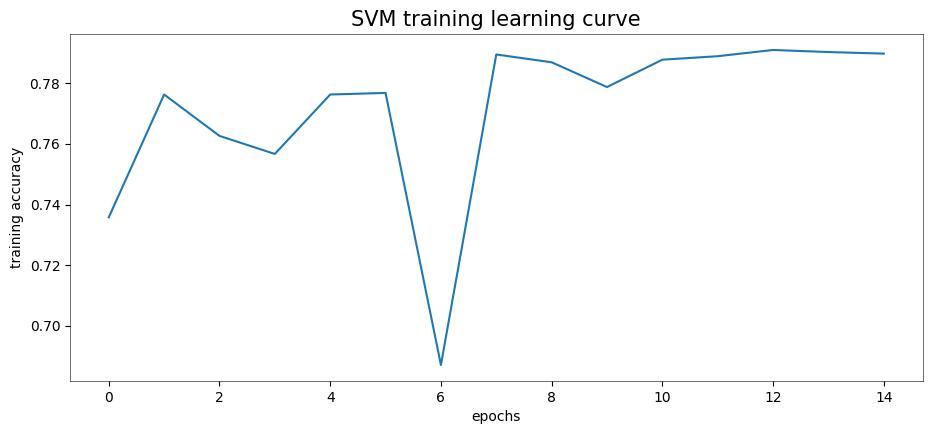

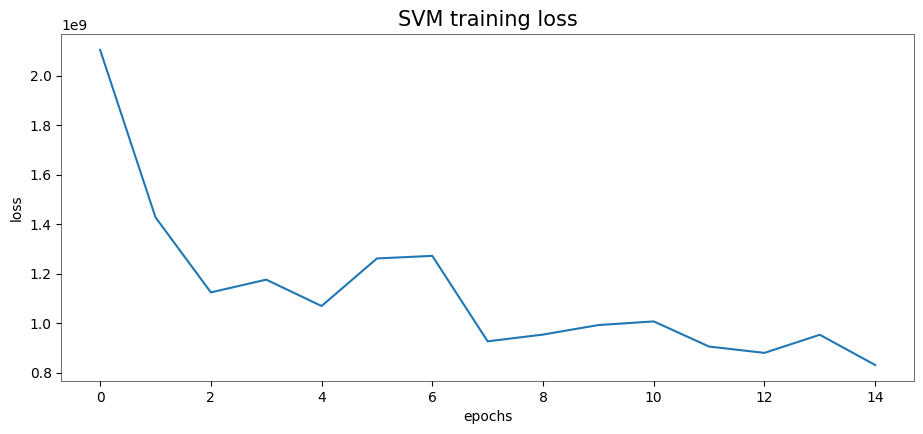

In [ ]:
learning_rate = 0.00001
C = 100000

epochs = 15
svm = SVM()
%time svm.train(misc_train_data,epochs,learning_rate,C)

# test set accuracy
# Get the best weights and bias from this training
W_misc,best_epoch_misc = svm.get_best_weights_and_bias()
# training set accuracy:
print("best training set accuracy: ", svm.accuracies[best_epoch_misc] )
# Use these weights and bias to evaluate on the test set
test_accuracy = svm.get_accuracy_own_weights(misc_test_data,W_misc)
print("final test accuracy: ",test_accuracy)

y = list(svm.accuracies.values())
x = [i for i in range(epochs)]
title = 'SVM training learning curve'
plot_learning(x,y,title,'epochs','training accuracy')

y = list(svm.loss.values())
x = [i for i in range(epochs)]
title = 'SVM training loss'
plot_learning(x,y,title,'epochs','loss')


Eh, not great, I'll try glove next.

In [ ]:
# Glove + Misc
train_data_glove = Data(TRAINING_PATH_GLOVE)
test_data_glove = Data(TESTING_PATH_GLOVE)

CPU times: user 4.66 s, sys: 1.39 s, total: 6.05 s
Wall time: 4.28 s
best training set accuracy:  0.7778857142857143
final test accuracy:  0.7688888888888888


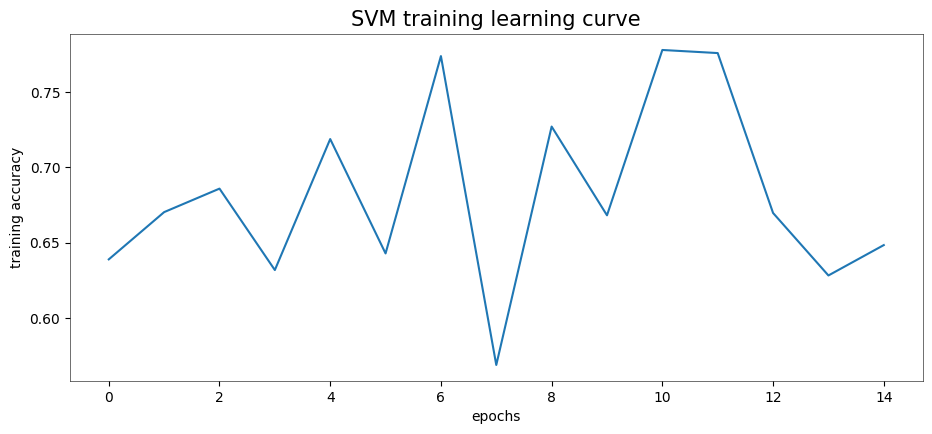

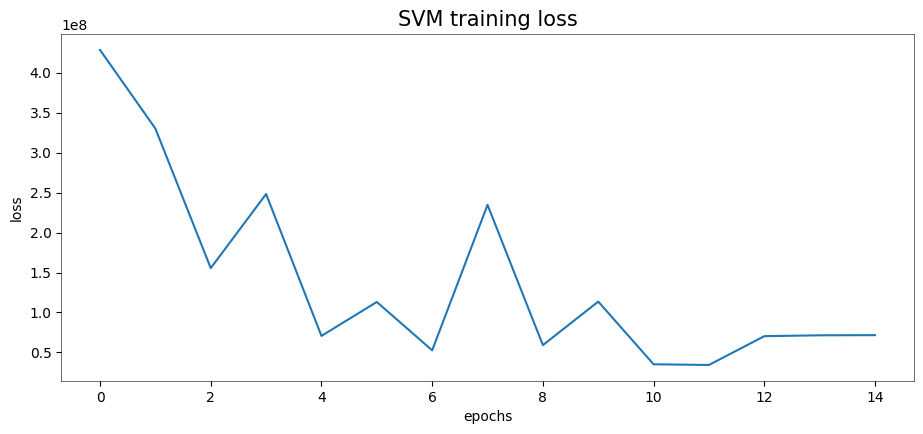

In [ ]:
learning_rate = 0.001
C = 1000

epochs = 15
svm = SVM()
%time svm.train(train_data_glove,epochs,learning_rate,C)

# test set accuracy
# Get the best weights and bias from this training
W_glove,best_epoch_misc = svm.get_best_weights_and_bias()
# training set accuracy:
print("best training set accuracy: ", svm.accuracies[best_epoch_misc] )
# Use these weights and bias to evaluate on the test set
test_accuracy = svm.get_accuracy_own_weights(test_data_glove,W_glove)
print("final test accuracy: ",test_accuracy)

y = list(svm.accuracies.values())
x = [i for i in range(epochs)]
title = 'SVM training learning curve'
plot_learning(x,y,title,'epochs','training accuracy')

y = list(svm.loss.values())
x = [i for i in range(epochs)]
title = 'SVM training loss'
plot_learning(x,y,title,'epochs','loss')

eh, not that great either. Will just stick with the tf-idf + misc features. 

# Run model on eval set

In [ ]:
# load eval data
eval_data = Data(EVAL_PATH_TF)

In [ ]:
# eval ids
def load_ids(file_path):
  with open(file_path) as f:
    raw_data = [int(line.split()[0]) for line in f]
  # print(raw_data)
  return raw_data

eval_ids = np.reshape(np.array(load_ids(EVAL_IDS),dtype=np.int32),(eval_data.X.shape[0],1))
# print(eval_ids)

# run predictions
predictions = np.sign(eval_data.X.dot(W))
print(predictions.shape)
print(predictions)
predictions[predictions == -1] = 0
predictions = np.reshape(predictions,(eval_data.X.shape[0],1))
print(predictions.shape)
print(predictions)
eval_out = np.hstack((eval_ids,predictions))
print(eval_out.shape)
print(eval_out)
eval_df = pd.DataFrame(data = eval_out,index = None,columns=['example_id','label'])
save_to_path = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/SVM_evals.csv'
eval_df.to_csv(path_or_buf=save_to_path,index=False)

(5250,)
[ 1. -1.  1. ...  1. -1. -1.]
(5250, 1)
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [0.]
 [0.]]
(5250, 2)
[[0.000e+00 1.000e+00]
 [1.000e+00 0.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.247e+03 1.000e+00]
 [5.248e+03 0.000e+00]
 [5.249e+03 0.000e+00]]


## Save weights for later use

In [ ]:
outfile = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/svm_weights.npy'
np.save(outfile, W)